# Energy Function


Energy function to solve the optimization problem of finding the **shortest path** between two nodes in a graph. This function combines multiple terms that impose constraints and objectives on the solution. Here is a general energy function for finding shortest paths without particularizing to a specific (orgin,destination) pair:

$$
F = \frac{\mu_1}{2} \sum_{i=1}^n \sum_{j=1}^n C_{ij} x_{ij} + 
    \frac{\mu_2}{2} \sum_{i=1}^n \left( \sum_{j=1}^n x_{ij} - 1 \right)^2 + 
    \frac{\mu_2}{2} \sum_{j=1}^n \left( \sum_{i=1}^n x_{ij} - 1 \right)^2 + 
    \frac{\mu_3}{2} \sum_{i=1}^n \sum_{j=1}^n x_{ij}(1 - x_{ij}) 
$$

## Components of the Energy Function

### 1. **Path Cost**
$$
\frac{\mu_1}{2} \sum_{i=1}^n \sum_{j=1}^n C_{ij} x_{ij}
$$
- **Description**: Minimizes the total cost of the path.
- **Variables**:
  - $C_{ij} $: Cost (or distance) between nodes $i$ and $j$.
  - $x_{ij} $: Binary variable indicating if the path between $i $ and $j$ is part of the solution $( x_{ij} = 1 $) or not $( x_{ij} = 0 $).
- **Purpose**: Encourges the selection of paths with lower cost.

---

### 2. **Row constraints**
$
\frac{\mu_2}{2} \sum_{i=1}^n \left( \sum_{j=1}^n x_{ij} - 1 \right)^2
$
- **Description**: This term ensures that each node has exactly **one outgoing edge**.
- **Variables**:
  - $\sum_{j=1}^n x_{ij} $: Represents number of outgoing edges from node $i$
- **Purpose**: Penalize solutions in which a node has more than one outgoing edge or none.

---

### 3. **Column constraints**
$
\frac{\mu_2}{2} \sum_{j=1}^n \left( \sum_{i=1}^n x_{ij} - 1 \right)^2
$
- **Description**: This term ensures that each node has exactly **one incoming edge**.
- **Variables**:
  - $\sum_{i=1}^n x_{ij} $: Represents number of incoming edges to node $j$.
- **Purpose**: Penalize solutions in which a node has more than one incoming edge or none. 

---

### 4. **Binariness constraint**
$
\frac{\mu_3}{2} \sum_{i=1}^n \sum_{j=1}^n x_{ij}(1 - x_{ij})
$
- **Description**: This term forces the variables $( x_{ij} $) to be binary (0 or 1).
- **Variables**:
  - $x_{ij} (1 - x_{ij}) $: This product is zero if $( x_{ij} $) is 0 or 1, but is positive if $( x_{ij} $) takes intermediate values.
- **Purpose**: Penalize solutions in which $x_{ij} $ takes values other than 0 or 1.

---

## Parameters
- $\mu_1, \mu_2, \mu_3 $: Weights that balance the importance of each term in the energy function. 
  - $ \mu_1 $: Prioritizes the minimization of the total cost of the path. 
  - $ \mu_2 $: Emphasis on path validity. 
  - $ \mu_3 $: Controls the binariness of the variables. 

---

## Summary
Energy Function combines **strong** (like path validity) and **weak** (like cost minimization and binariness) constraints to: 
1. **Find a valid path**.
2. **Minimize the total cost of the path**.



---

## DATA PREPARATION
Transform the adjacency matrix into a cost matrix.

In [22]:
import pandas as pd
import numpy as np

# Load data from CSV file
try:
    df = pd.read_csv('../data/synthetic/synthetic_network.csv')
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except pd.errors.EmptyDataError:
    print("Error: The file is empty or invalid.")
    exit()

# Identify unique nodes and create a mapping for indices
nodos = sorted(set(df['origin']).union(set(df['destination'])))
node_to_index = {node: idx for idx, node in enumerate(nodos)}
n = len(nodos)

# Initialize the cost matrix with infinity
cost_matrix = np.full((n, n), np.inf)


# Set diagonal to 0 (self-costs)
np.fill_diagonal(cost_matrix, 0)

# Fill the cost matrix with the values from the CSV
for _, row in df.iterrows():
    try:
        origen = row['origin']
        destino = row['destination']
        costo = float(row['weight'])
        cost_matrix[node_to_index[origen], node_to_index[destino]] = costo
    except KeyError:
        print("Error: Missing columns 'origen', 'destino', or 'costo'.")
        exit()
    except ValueError:
        print(f"Error: Invalid cost value on row {_}.")
        exit()

# Display the cost matrix
print("Cost Matrix:")
print(cost_matrix)




Cost Matrix:
[[  0.  inf 120. 164.  inf  inf  inf  inf 125.  28.]
 [ inf   0. 135.  inf  inf 157. 100.  62.  inf  inf]
 [167.  inf   0. 119. 169. 171.  inf  72. 200.  inf]
 [ inf  inf  15.   0. 141.  inf  37. 154. 150.  18.]
 [ inf  inf  inf  14.   0. 170. 138. 100.  inf  inf]
 [ 75. 103.  inf  46. 144.   0.  inf 157. 129.  44.]
 [138. 156.  96.  83.  inf  20.   0.  inf  47.  inf]
 [ inf  65.  10.  inf  inf  85.  70.   0.  inf 176.]
 [ 23.  inf  inf  inf  57.  inf  55.  inf   0. 140.]
 [ inf 146.  inf 143.  inf 166.  inf 153. 178.   0.]]


---

## NEURAL MODEL

In [23]:
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle

# Load, normalize and flatten the distance matrix, assigning a large value to infinity values
cost_matrix[cost_matrix == np.inf] = 1e6
cost_matrix_normalized = (cost_matrix - np.min(cost_matrix)) / (np.max(cost_matrix) - np.min(cost_matrix) + 1e-6)
cost_matrix_flat = cost_matrix_normalized.flatten()
distance_matrix = cost_matrix_flat


# Number of nodes
n = distance_matrix.shape[0]

# Hyperparameters (weights for energy terms)
mu1 = 1.0
mu2 = 10.0
mu3 = 10.0

# Define the Hopfield Neural Network model
class HopfieldNN:
    def __init__(self, n, distance_matrix):
        self.n = n
        self.distances = tf.constant(distance_matrix, dtype=tf.float32)
        # Variables representing the binary decision for each edge
        self.x = tf.Variable(tf.random.uniform([n, n], minval=0, maxval=1, dtype=tf.float32))

    def energy(self):
        # Term 1: Path cost
        term1 = (mu1 / 2) * tf.reduce_sum(self.distances * self.x)

        # Term 2: Row constraints
        row_sums = tf.reduce_sum(self.x, axis=1) - 1
        term2 = (mu2 / 2) * tf.reduce_sum(tf.square(row_sums))

        # Term 3: Column constraints
        col_sums = tf.reduce_sum(self.x, axis=0) - 1
        term3 = (mu2 / 2) * tf.reduce_sum(tf.square(col_sums))

        # Term 4: Binary constraint
        term4 = (mu3 / 2) * tf.reduce_sum(self.x * (1 - self.x))
        
        # Combine all terms
        return term1 + term2 + term3 + term4
        
    
    def fine_tune_with_constraints(self, source, destination, learning_rate=0.1, iterations=500):
        optimizer = tf.optimizers.Adam(learning_rate)
        for i in range(iterations):
            with tf.GradientTape() as tape:
                # Fine-tune with source and destination constraints
                source_out = tf.reduce_sum(self.x[source, :]) - 1
                term5 = (10.0 / 2) * tf.square(source_out)

                dest_in = tf.reduce_sum(self.x[:, destination]) - 1
                term6 = (10.0 / 2) * tf.square(dest_in)

                energy = term5 + term6

            gradients = tape.gradient(energy, [self.x])
            optimizer.apply_gradients(zip(gradients, [self.x]))
            # Clip the variables to [0, 1] to enforce valid range
            self.x.assign(tf.clip_by_value(self.x, 0.0, 1.0))
            if i % 100 == 0:
                print(f"Fine-Tuning Iteration {i}, Energy: {energy.numpy()}")
        return self.x

    def train(self, learning_rate=0.1, iterations=1000):
        optimizer = tf.optimizers.Adam(learning_rate)
        for i in range(iterations):
            with tf.GradientTape() as tape:
                energy = self.energy()
            gradients = tape.gradient(energy, [self.x])
            optimizer.apply_gradients(zip(gradients, [self.x]))
            # Clip the variables to [0, 1] to enforce valid range
            self.x.assign(tf.clip_by_value(self.x, 0.0, 1.0))
            if i % 100 == 0:
                print(f"Iteration {i}, Energy: {energy.numpy()}")
        return self.x
    
    def save_model(self, file_name):
        with open(file_name, 'wb') as f:
            pickle.dump(self.x.numpy(), f)
            
    def load_model(self, file_name):
        with open(file_name, 'rb') as f:
            loaded_x = pickle.load(f)
            self.x.assign(loaded_x)
            
# Create the model
model = HopfieldNN(n, distance_matrix)
model.save_model("../models/trained_model_without_source_dest.pkl")

# Train the model to minimize the energy function
optimized_x = model.train()

# Extract the shortest path from the optimized variables
def extract_path(x):
    x_binary = tf.cast(tf.round(x), tf.int32).numpy()
    path = []
    current_node = 0
    visited = set()
    while len(path) < n:
        path.append(current_node)
        visited.add(current_node)
        next_node = np.argmax(x_binary[current_node])
        if next_node in visited:  # Avoid cycles
            break
        current_node = next_node
    return path

shortest_path = extract_path(optimized_x)
print("Shortest Path:", shortest_path)



Iteration 0, Energy: 2385676.25
Iteration 100, Energy: 449.5957336425781
Iteration 200, Energy: 448.9297180175781
Iteration 300, Energy: 448.6121826171875
Iteration 400, Energy: 445.54510498046875
Iteration 500, Energy: 434.6236877441406
Iteration 600, Energy: 405.3708190917969
Iteration 700, Energy: 331.0356750488281
Iteration 800, Energy: 198.4976806640625
Iteration 900, Energy: 80.30445861816406
Shortest Path: [0, 3, 19, 38, 63, 79, 92, 86, 23, 69, 6, 52, 26, 42, 49, 47, 71, 96, 53, 1, 43, 90, 28, 82, 36, 51, 66, 41, 34, 33, 99, 75, 31, 15, 35, 58, 94, 60, 27]


## Source and destination node restrictions

**Term 5: Source Node Constraint**

$
\left( \sum_{j=1}^n x_{s,j} - 1 \right)^2
$

- $x_{s,j}$: Binary decision variable for the edge from source node $s$ to node $j$.
- Ensures that the source node $s$ has exactly one outgoing edge.

**Term 6: Destination Node Constraint**

$
\left( \sum_{i=1}^n x_{i,d} - 1 \right)^2
$

- $ x_{i,d} $: Binary decision variable for the edge from node $ i $ to the destination node $ d $.
- Ensures that the destination node $ d $ has exactly one incoming edge.


### Fine tuning with source and destination constraints

In [24]:
source_node = 0
destination_node = 5

# Reload the model and fine-tune with source and destination constraints
model.load_model("../models/trained_model_without_source_dest.pkl")
optimized_x_with_constraints = model.fine_tune_with_constraints(source_node, destination_node)

# Extract the shortest path from the optimized variables
def extract_path(x):
    x_binary = tf.cast(tf.round(x), tf.int32).numpy()
    path = []
    current_node = source_node
    visited = set()
    while current_node != destination_node:
        path.append(current_node)
        visited.add(current_node)
        next_node = np.argmax(x_binary[current_node])
        if next_node in visited or next_node == destination_node:
            break
        current_node = next_node
    path.append(destination_node)
    return path

shortest_path = extract_path(optimized_x_with_constraints)
print("Shortest Path:", shortest_path)

Fine-Tuning Iteration 0, Energy: 2407600.0
Fine-Tuning Iteration 100, Energy: 449.9800109863281
Fine-Tuning Iteration 200, Energy: 449.2978820800781
Fine-Tuning Iteration 300, Energy: 448.9851379394531
Fine-Tuning Iteration 400, Energy: 445.98223876953125
Shortest Path: [0, 5]


### Cost of the shortest path

In [25]:
# Calculate the cost of the shortest path
# Adjusted to account for the real cost matrix (not normalized)
def calculate_real_path_cost(real_cost_matrix, path):
    cost = 0
    for i in range(len(path) - 1):
        cost += real_cost_matrix[path[i], path[i + 1]]
    return cost

path_cost = calculate_real_path_cost(cost_matrix, shortest_path)
print("Cost of the Shortest Path (Real Costs):", path_cost)

Cost of the Shortest Path (Real Costs): 1000000.0


### Visualization of the shortest path

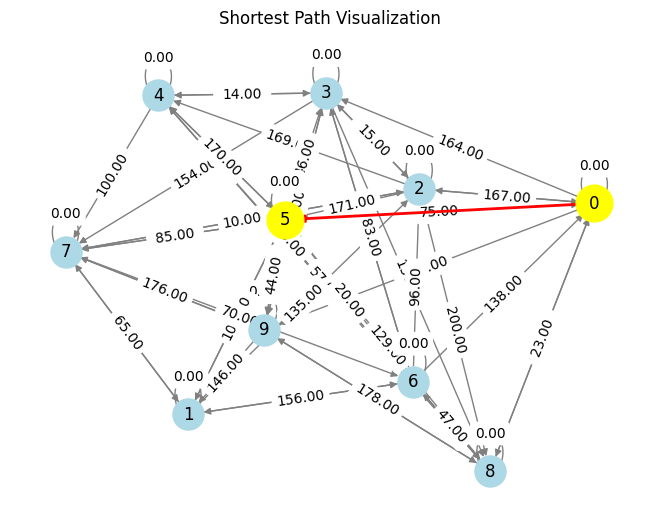

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

# Visualization of the shortest path using NetworkX
def visualize_shortest_path(real_cost_matrix, shortest_path):
    G = nx.DiGraph()
    n = real_cost_matrix.shape[0]

    # Add edges with weights
    for i in range(n):
        for j in range(n):
            if real_cost_matrix[i, j] < 1e6:  # Exclude large values (representing infinity)
                G.add_edge(i, j, weight=real_cost_matrix[i, j])

    # Generate positions for nodes
    pos = nx.spring_layout(G)

    # Draw the entire graph
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=500, edge_color="gray")
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): f"{d['weight']:.2f}" for i, j, d in G.edges(data=True)})

    # Highlight the shortest path
    path_edges = [(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_color="yellow", node_size=700)

    plt.title("Shortest Path Visualization")
    plt.show()

visualize_shortest_path(cost_matrix, shortest_path)

